# L2: Building a Simple Web Agent

Note: The images and code snippets are taken from the "Building AI Browser

#### Here we are going to build a simple web agent that will scrape through the deeplearning.ai website and give us the intented result in a structuted format.  

## Let's call this "Learning Recommender Agent"

This is what the agent is going to do:
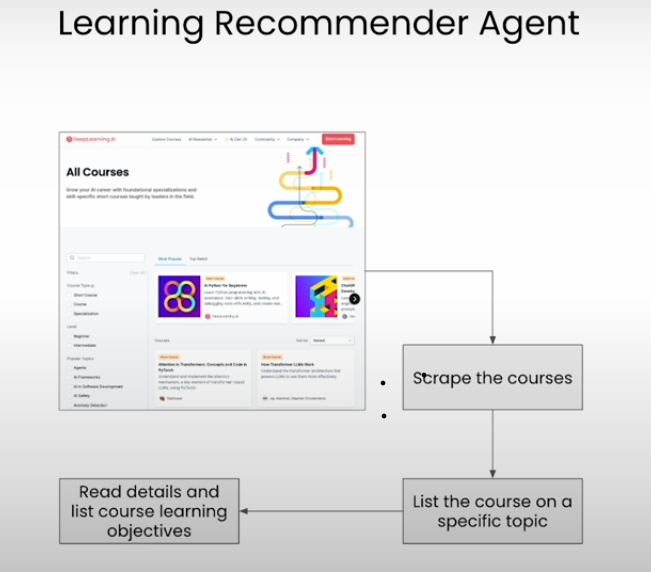

<p style="background-color:#fff6e4; padding:15px; border-width:3px; border-color:#f5ecda; border-style:solid; border-radius:6px"> ⏳ <b>Note <code>(Kernel Starting)</code>:</b> This notebook takes about 30 seconds to be ready to use. You may start and watch the video while you wait.</p>

In [1]:
import asyncio                # For running asynchronous code
import json                   # For parsing and generating JSON
import os                     # For environment access, if needed
import nest_asyncio           # Allows nested event loops (e.g., in Jupyter)
import pprint                 # Pretty print for easier debugging
import base64                 # Used to encode/decode image bytes
from io import BytesIO        # For handling image byte streams
import pandas as pd           # For structured data manipulation
from playwright.async_api import async_playwright  # Browser automation (async version)
from openai import OpenAI     # OpenAI Python client
from PIL import Image         # Image manipulation library
from tabulate import tabulate # For tabular display of data
from IPython.display import display, HTML, Markdown  # Jupyter-friendly outputs
from pydantic import BaseModel  # For data validation and type safety
from helper import get_openai_api_key, visualizeCourses  # Custom helper methods (assumed defined elsewhere)


<div style="background-color:#fff6ff; padding:13px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
<p> 💻 &nbsp; <b>Access <code>requirements.txt</code> and <code>helper.py</code> files:</b> 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Open"</em>.

<p> ⬇ &nbsp; <b>Download Notebooks:</b> 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Download as"</em> and select <em>"Notebook (.ipynb)"</em>.</p>

<p> 📒 &nbsp; For more help, please see the <em>"Appendix – Tips, Help, and Download"</em> Lesson.</p>
</div>

In [2]:
client = OpenAI(api_key=get_openai_api_key())
nest_asyncio.apply()

## WebScraper Agent
### Define a Web Scraper Agent using Playwright

In [3]:
class WebScraperAgent:
    def __init__(self):
        self.playwright = None  # Playwright controller
        self.browser = None     # Headless browser
        self.page = None        # Browser tab/page

    #Initializes a headless Chromium browser with performance and security options disabled for smoother scraping.
    async def init_browser(self):
      self.playwright = await async_playwright().start()  # Start Playwright service
      self.browser = await self.playwright.chromium.launch(
          headless=True,
          args=[
              "--disable-dev-shm-usage",  # Memory optimizations
              "--no-sandbox",
              "--disable-setuid-sandbox",
              "--disable-accelerated-2d-canvas",
              "--disable-gpu",
              "--no-zygote",
              "--disable-audio-output",
              "--disable-software-rasterizer",
              "--disable-webgl",
              "--disable-web-security",
              "--disable-features=LazyFrameLoading",
              "--disable-features=IsolateOrigins",
              "--disable-background-networking"
          ]
      )
      self.page = await self.browser.new_page()  # Create a new browser page

    async def scrape_content(self, url):
        if not self.page or self.page.is_closed():  # Re-initialize if page is closed
            await self.init_browser()
        await self.page.goto(url, wait_until="load")  # Navigate to the target URL
        await self.page.wait_for_timeout(2000)        # Wait for JS content to load
        return await self.page.content()              # Return full HTML content

    async def take_screenshot(self, path="screenshot.png"):
        await self.page.screenshot(path=path, full_page=True)  # Full page screenshot
        return path  # Return screenshot path
    
    async def screenshot_buffer(self):
        # Capture screenshot as byte stream (for display in notebooks, etc.)
        screenshot_bytes = await self.page.screenshot(type="png", full_page=False)
        return screenshot_bytes

    async def close(self):
        # Gracefully close browser and clean up
        await self.browser.close()
        await self.playwright.stop()
        self.playwright = None
        self.browser = None
        self.page = None

In [4]:
scraper = WebScraperAgent()

## Structured Data Format
###  Define Schema for Course Output using Pydantic

In [5]:
# This model defines the fields expected for each course.
class DeeplearningCourse(BaseModel):
    title: str
    description: str
    presenter: list[str]
    imageUrl: str
    courseURL: str

# Wraps all course items in a list for structured validation.
class DeeplearningCourseList(BaseModel):
    courses: list[DeeplearningCourse]

## LLM Client for Open AI

In [6]:
async def process_with_llm(html, instructions, truncate = False):
    completion = client.beta.chat.completions.parse(
        model="gpt-4o-mini-2024-07-18",
        messages=[{
            "role": "system",
            "content": f"""
            You are an expert web scraping agent. Your task is to:
            Extract relevant information from this HTML to JSON 
            following these instructions:
            {instructions}
            
            Extract the title, description, presenter, 
            the image URL and course URL for each of 
            all the courses for the deeplearning.ai website

            Return ONLY valid JSON, no markdown or extra text."""
        }, {
            "role": "user",
            "content": html[:150000]  # Truncate to stay under token limits
        }],
        temperature=0.1,  # Very low randomness for predictable structure
        response_format=DeeplearningCourseList,  # Enforce valid structured output
        )
    return completion.choices[0].message.parsed   # Extract parsed structured response

### Web Scraper Controller

In [7]:
async def webscraper(target_url, instructions):
    result = None
    try:
        # Scrape content and capture screenshot
        print("Extracting HTML Content \n")
        html_content = await scraper.scrape_content(target_url)   # Scrape HTML

        print("Taking Screenshot \n")
        screenshot = await scraper.screenshot_buffer()  # Capture screenshot as bytes
        # Process content

        print("Processing..")
        result: DeeplearningCourseList = await process_with_llm(html_content, instructions, False)
        print("\nGenerated Structured Response")
    except Exception as e:
        print(f"❌ Error: {str(e)}")
    finally:
        await scraper.close()
    return result, screenshot

## Example 1

In [8]:
target_url = "https://www.deeplearning.ai/courses"  # Deeplearning AI courses
base_url="https://deeplearning.ai"

In [9]:
instructions = """
    Get all the courses
"""
result, screenshot = await webscraper(target_url, instructions)

Extracting HTML Content 

Taking Screenshot 

Processing..

Generated Structured Response


### Scraped Course Data:

title,description,presenter,imageUrl,courseURL
AI Python for Beginners,"Learn Python programming with AI assistance. Gain skills writing, testing, and debugging code efficiently, and create real-world AI applications.",DeepLearning.AI,,AI Python for Beginners
ChatGPT Prompt Engineering for Developers,"Learn the fundamentals of prompt engineering for ChatGPT. Learn effective prompting, and how to use LLMs for summarizing, inferring, transforming, and expanding.",OpenAI,,ChatGPT Prompt Engineering for Developers
Generative AI for Everyone,"Learn how to use generative AI's capabilities & limitations. Get an overview of real-world examples, and impact on business & society for effective strategies.",DeepLearning.AI,,Generative AI for Everyone
Machine Learning Specialization,"Learn foundational AI concepts through an intuitive visual approach, then learn the code needed to implement the algorithms and math for ML.",Stanford Online,,Machine Learning Specialization
Multi AI Agent Systems with crewAI,Automate business workflows with multi-AI agent systems. Exceed the performance of prompting a single LLM by designing and prompting a team of AI agents through natural language.,crewAI,,Multi AI Agent Systems with crewAI
LangChain for LLM Application Development,"Use the powerful and extensible LangChain framework, using prompts, parsing, memory, chains, question answering, and agents.",LangChain,,LangChain for LLM Application Development
AI for Everyone,"Learn about AI technologies and how to use them. Examine AI's societal impact, and learn to navigate this technological shift.",DeepLearning.AI,,AI for Everyone
Data Analytics Professional Certificate,"Build a solid data analytics foundation using industry standard and AI tools to extract insights, make decisions, and solve real-world business problems.",DeepLearning.AI,,Data Analytics Professional Certificate
Orchestrating Workflows for GenAI Applications,Turn your GenAI prototype into an automated pipeline using Apache Airflow,Astronomer,,Orchestrating Workflows for GenAI Applications
DSPy: Build and Optimize Agentic Apps,"Build, debug, and optimize AI agents using DSPy and MLflow.",Databricks,,DSPy: Build and Optimize Agentic Apps


### Website Screenshot:


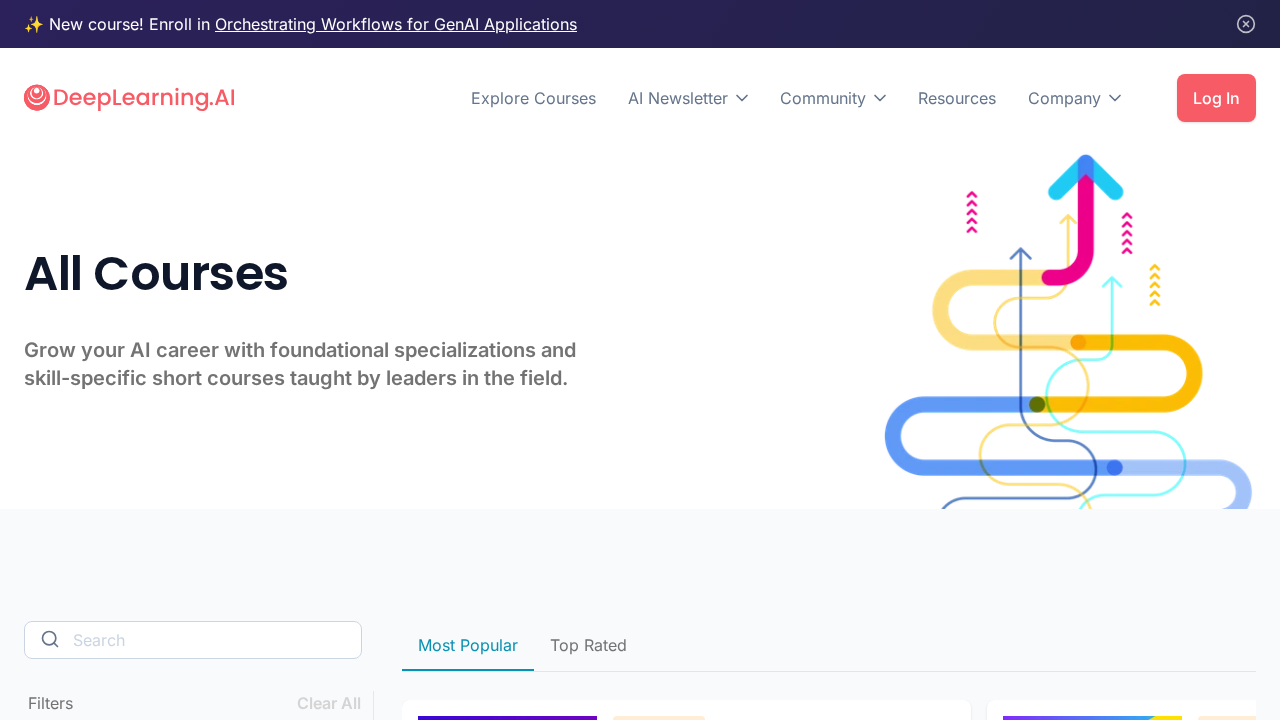

In [10]:
await visualizeCourses(result=result, 
                       screenshot=screenshot, 
                       target_url=target_url, 
                       instructions=instructions, 
                       base_url=base_url)

## Example with RAG courses

In [11]:
subject = "Retrieval Augmented Generation (RAG) "

instructions = f"""
Read the description of the courses and only 
provide the three courses that are about {subject}. 
Make sure that we don't have any other
cources in the output
"""
result, screenshot = await webscraper(target_url, instructions)

Extracting HTML Content 

Taking Screenshot 

Processing..

Generated Structured Response


### Scraped Course Data:

title,description,presenter,imageUrl,courseURL
Event-Driven Agentic Document Workflows,Build an event-driven agentic workflow to process documents and fill forms using RAG and human-in-the-loop feedback.,LlamaIndex,,Event-Driven Agentic Document Workflows
Long-Term Agentic Memory with LangGraph,"Learn to build AI agents with long-term memory with LangGraph, using LangMem for memory management.",LangChain,,Long-Term Agentic Memory with LangGraph
Building Apps with Windsurf’s AI Coding Agents,"Learn to build, debug, and deploy applications with an Agentic AI-powered integrated development environment.",Windsurf,,Building Apps with Windsurf’s AI Coding Agents


### Website Screenshot:


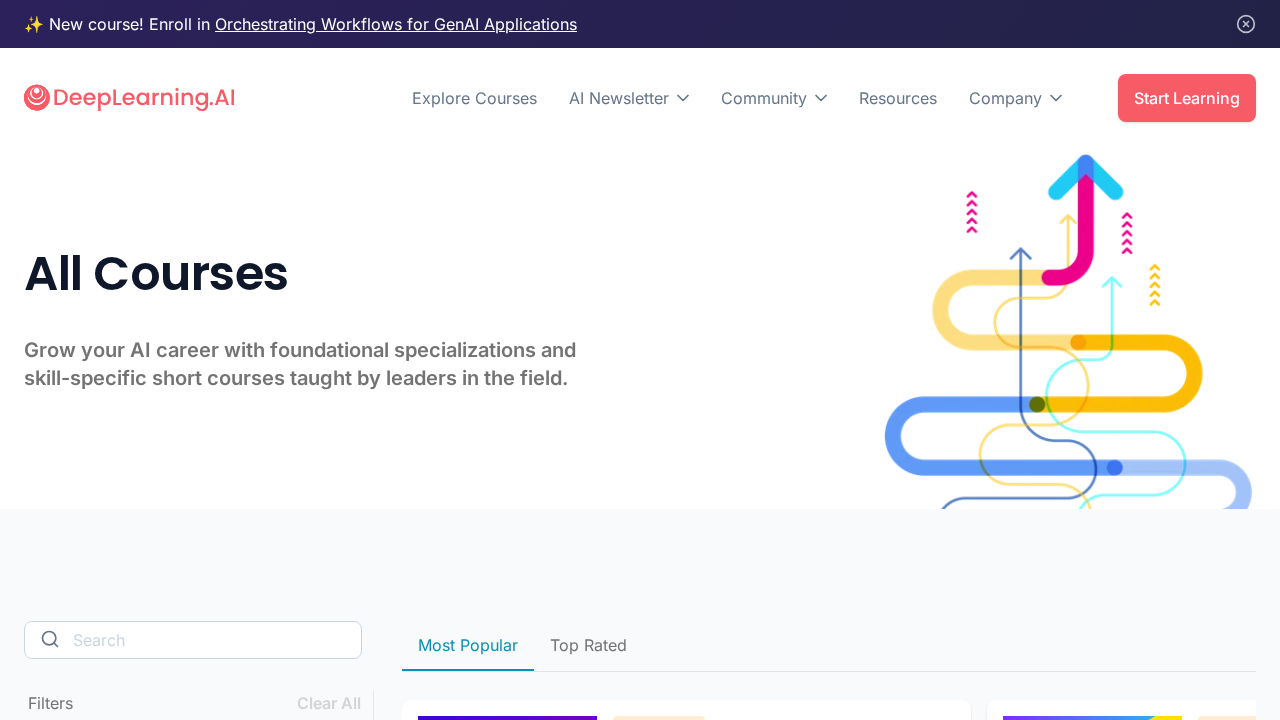

In [12]:
await visualizeCourses(result=result, 
                       screenshot=screenshot, 
                       target_url=target_url, 
                       instructions=instructions, 
                       base_url=base_url)

## Challenges in the web agents

In [15]:
subject = "Retrieval Augmented Generation (RAG) "
instructions = f"""
Can you get the summary of the top course on
{subject} provide the learnings from it
"""
result, screenshot = await webscraper(target_url, instructions)

Extracting HTML Content 

Taking Screenshot 

Processing..

Generated Structured Response


### Scraped Course Data:

title,description,presenter,imageUrl,courseURL
AI Python for Beginners,"Learn Python programming with AI assistance. Gain skills writing, testing, and debugging code efficiently, and create real-world AI applications.",DeepLearning.AI,,AI Python for Beginners
ChatGPT Prompt Engineering for Developers,"Learn the fundamentals of prompt engineering for ChatGPT. Learn effective prompting, and how to use LLMs for summarizing, inferring, transforming, and expanding.",OpenAI,,ChatGPT Prompt Engineering for Developers
Generative AI for Everyone,"Learn how to use generative AI's capabilities & limitations. Get an overview of real-world examples, and impact on business & society for effective strategies.",DeepLearning.AI,,Generative AI for Everyone
Machine Learning Specialization,"Learn foundational AI concepts through an intuitive visual approach, then learn the code needed to implement the algorithms and math for ML.",Stanford Online,,Machine Learning Specialization
Multi AI Agent Systems with crewAI,Automate business workflows with multi-AI agent systems. Exceed the performance of prompting a single LLM by designing and prompting a team of AI agents through natural language.,crewAI,,Multi AI Agent Systems with crewAI
LangChain for LLM Application Development,"Use the powerful and extensible LangChain framework, using prompts, parsing, memory, chains, question answering, and agents.",LangChain,,LangChain for LLM Application Development
AI for Everyone,"Learn about AI technologies and how to use them. Examine AI's societal impact, and learn to navigate this technological shift.",DeepLearning.AI,,AI for Everyone


### Website Screenshot:


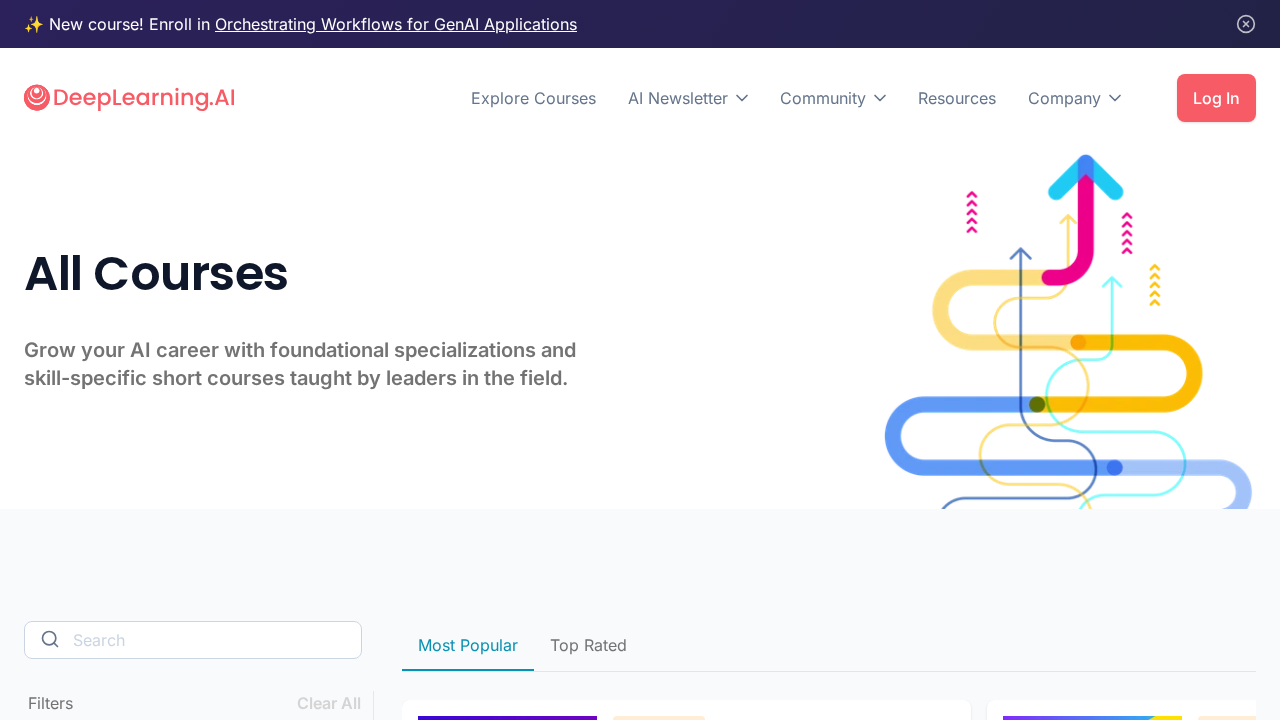

In [16]:
await visualizeCourses(result=result,
                       screenshot=screenshot,
                       target_url=target_url,
                       instructions=instructions,
                       base_url=base_url)

#### As you can see, the instructions were to get the summary of top course provide the learnings from it, but our agent was unable to do so, rather it gave list of all courses. This happens when the instructions are unclear or agent lacks the necessary capabilities.